# Riconoscimento efficiente di immagini di animali tramite transfer learning e quantizzazione

 Il progetto si pone come obiettivo il riconoscimento di diverse specie di animali a partire da
 fotografie, utilizzando una rete neurale. Il dataset di riferimento (animals.zip) contiene
 immagini di animali precedentemente etichettate.
 Il progetto richiede di sviluppare una soluzione con attenzione sia all’accuratezza del
 modello che al costo computazionale associato. Nello specifico, si richiede di:



*   Utilizzare la tecnica del transfer learning per sfruttare un modello pre-addestrato (a
 scelta) come punto di partenza nello sviluppo della soluzione.


*    Studiare ed utilizzare, dopo l’addestramento, la tecnica della quantizzazione dei pesi,
 per ridurre la dimensione del modello e migliorare le prestazioni in fase di inferenza.
 A tal fine si raccomanda la lettura di:(https://ai.google.dev/edge/litert/models/post_training_integer_quant)


*   Confrontare le prestazioni del modello (in termini sia di accuratezza che costo com
putazionale) con e senza quantizzazione


*   tra le opzioni T3a e T3b ho scelto l'opzione T3b che consiste nel confrontare le prestazioni del modello ottenuto partendo da almeno 2
 diversi modelli pre-addestrato


# Sommario



1.  Preparazione dell'ambiente.
2.  Analisi e Preprocessing del dataset.
3.  Scelta, integrazione e tuning sui modelli pre-addestrati.
4.  Addestramento dei modelli base, calcolo di accuracy e costo computazionale.
5.  Quantizzazione dei modelli.
6.  Inferenza sui modelli quantizzati.
6.  Confronto delle prestazioni.
7.  Conclusioni.





# 1) PREPARAZIONE DELL'AMBIENTE

in questa cella andiamo ad installare e caricare le librerie che saranno utili per lo svolgimento della traccia

In [4]:
!pip install keras-tuner --quiet

In [ ]:
# Fornisce strumenti per costruire e addestrare reti neurali.
import tensorflow as tf

# API integrate in TensorFlow per costruire e addestrare modelli di deep learning.
import keras

# Serve per l'ottimizzazione degli iperparametri nei modelli di deep learning
import keras_tuner as kt

# Operazioni numeriche ad alte prestazioni per gestire array e matrici.
import numpy as np

# Serve per la visualizzazione grafica dei dati e delle metriche
import matplotlib.pyplot as plt

# Serve per interagire con il file system
import os

# Serve per gestire gli archivi compressi .zip
import zipfile

# Serve per effettuare operazioni sui file (ci serve per organizzare in modo corretto le cartelle)
import shutil

# Permette il caricamento di file (nel nostro caso il dataset) nell'ambiente Google Colab
from google.colab import files

# Usiamo Pandas per elaborare e analizzare i dati (rappresentazione in tabella)
import pandas as pd

# Modulo che useremo per misurare intervalli di tempo (la useremo per il calcolo del tempi di inferenza medio)
import time

# Sono i moduli che contengono i metodi di pre-processing dei dati (utili per adattare bene le feature ai modelli pre-addestrati)
from keras.applications.mobilenet_v2 import preprocess_input 
from keras.applications.resnet50 import preprocess_input 

# 2) ANALISI E PREPROCESSING DEL DATASET

2.1  Carichiamo il file animals.zip su colab ed estraiamo il contenuto.

2.2 Definiamo le variabili img_size, batch_size.

2.3 Creiamo training_dataset e validation_dataset utilizzando la funzione *image_dataset_from_directory()* e applicando il preprocessing dei relativi modelli:
    cosi da adattare il dataset alle richieste dei modelli pre-addestrati.
    

2.4 Salvataggio delle classi target e visualizzazione di esempi di features (prima e dopo aver effettuato il pre-processing).





Saving animals.zip to animals.zip
Found 26128 files belonging to 10 classes.
Using 20903 files for training.
Found 26128 files belonging to 10 classes.
Using 5225 files for validation.
Classi viste dal dataset: ['cane', 'cavallo', 'elefante', 'farfalla', 'gallina', 'gatto', 'mucca', 'pecora', 'ragno', 'scoiattolo']


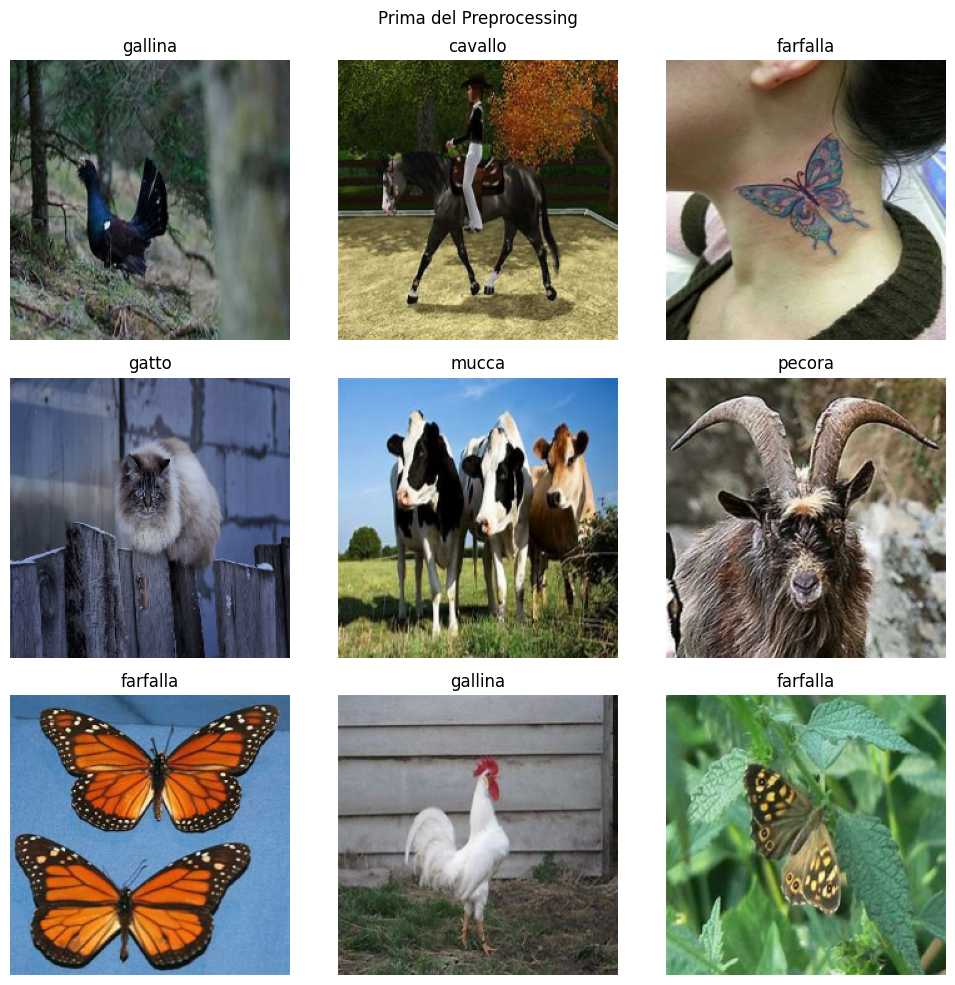

In [ ]:
# 2.1 caricamento del dataset
uploaded = files.upload()

# Estrazione del file ZIP
zip_path = 'animals.zip'
extract_path = '/content/animals'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


# Sistemazione della struttura delle cartelle (per una problematica relativa alle etichette, dove visualizzava solo animals come etichetta e non le singole etichette)
inner_path = os.path.join(extract_path, 'animals')
if os.path.exists(inner_path):
    for folder in os.listdir(inner_path):
        src = os.path.join(inner_path, folder)
        dst = os.path.join(extract_path, folder)
        if not os.path.exists(dst):
            shutil.move(src, dst)

    # Rimuove la cartella 'animals/animals' dopo aver sistemate il tutto
    shutil.rmtree(inner_path)

# 2.2 Definiamo i parametri comuni del nostro dataset
img_size = (224, 224)
batch_size = 32


# 2.3 Caricamento dei dataset (training e validation)
raw_train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

# applicazione preprocessing relativi ai training set
train_dataset_MobileNetV2 = raw_train_dataset.map(lambda x, y: (keras.applications.mobilenet_v2.preprocess_input(x), y))
train_dataset_ResNet50 = raw_train_dataset.map(lambda x, y: (keras.applications.resnet50.preprocess_input(x), y))

raw_val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    extract_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=img_size,
    batch_size=batch_size,
)

# applicazione preprocessing relativi ai validation set
val_dataset_MobileNetV2 = raw_val_dataset.map(lambda x, y: (keras.applications.mobilenet_v2.preprocess_input(x), y))
val_dataset_ResNet50 = raw_val_dataset.map(lambda x, y: (keras.applications.resnet50.preprocess_input(x), y))

# 2.4  Salvataggio delle classi e visualizzazione delle feature grezze e dopo il preprocessing
class_names = raw_train_dataset.class_names
print("Classi viste dal dataset:", class_names)

#  Visualizzazione di alcune immagini del training set senza aver effettuato il pre-processing
plt.figure(figsize=(10, 10))
plt.suptitle("Prima del Preprocessing")
for images, labels in raw_train_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
plt.tight_layout()
plt.show()

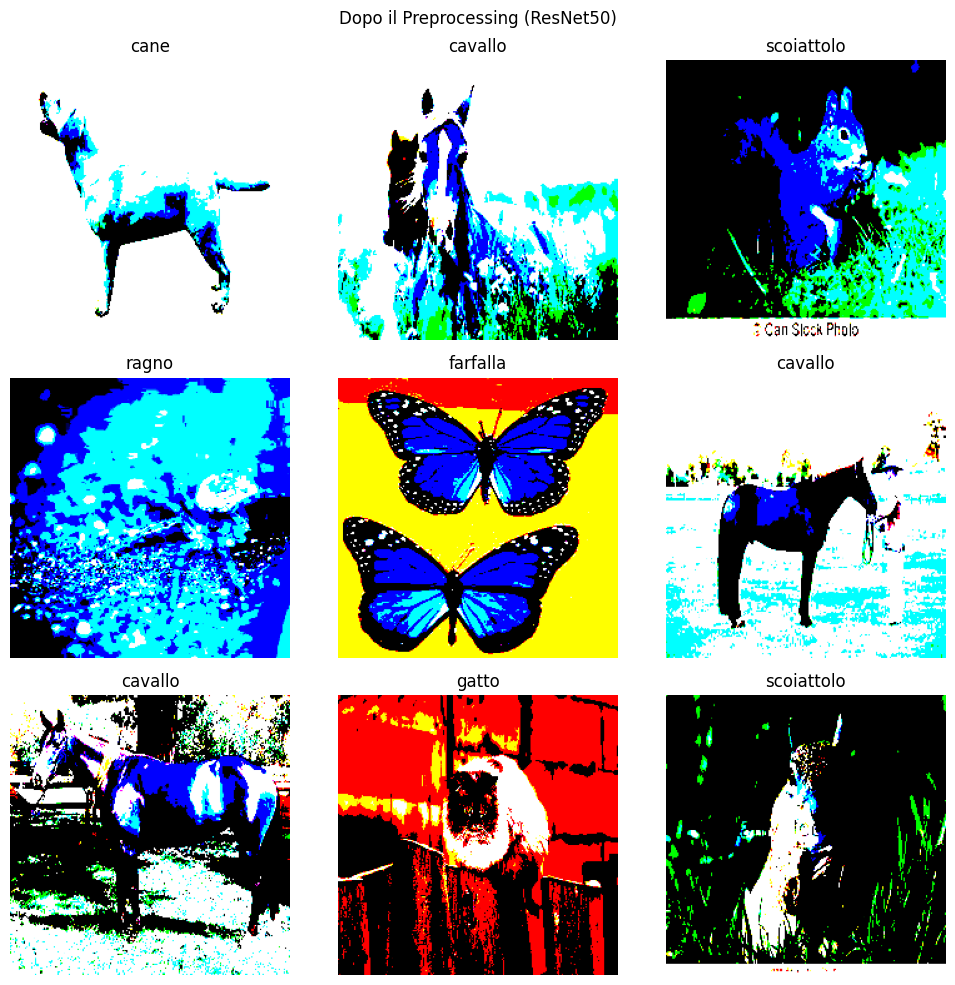

In [7]:
# Visualizzazione di alcuni esempi di immagini dopo aver effettuato il preprocessing per adattarle ai modelli
plt.figure(figsize=(10, 10))
plt.suptitle("Dopo il Preprocessing (ResNet50)")
for images, labels in train_dataset_ResNet50.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[int(labels[i].numpy())])
        plt.axis("off")
plt.tight_layout()
plt.show()

# 3) SCELTA, INTEGRAZIONE E TUNING SUI MODELLI PRE-ADDESTRATI


3.1  Definizione dei modelli con l'integrazione di MobileNetV2 e ResNet50.
   Scelta di Optimizator, loss e metrica.

3.2  Definizione della funzione di early_stopping e creazione dei tuner per MobilNetV2 e ResNet50.

3.3  Tuning e salvataggio dei modelli migliori con stampa dei relativi iperparametri ideali (operazione effettuata in precedenza).


In [8]:

# 3.1 Creazione del modello relativo a MobileNetV2

def build_model_MobileNetV2():

  #Inserimento del modello pre-addestrato

  base_model  = tf.keras.applications.MobileNetV2(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet',
  )

  #Definiamo non allenabile il base_model scelto

  base_model.trainable = False

  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  #Costruzione del modello superiore (valori ricercati precedentemente tramite keras-tuner)

  x = tf.keras.layers.Dense(units=352, activation='relu')(x)
  x= tf.keras.layers.Dropout(0.4)(x)

  #Layer di output con 10 unità (come le classi di etichette) e softmax (usata per classificazione multiclasse)

  outputs = tf.keras.layers.Dense(units=10, activation="softmax")(x)
  model_MobileNetV2 = tf.keras.Model(inputs, outputs)

# Definiamo il compilatore (anche qui abbiamo utilizzato keras_tuner per trovare il valore ideale del learning_rate)

  model_MobileNetV2.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.000131),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  return model_MobileNetV2








# Creazione del modello relativo a ResNet50

def build_model_ResNet50():

  #Inserimento del modello pre-addestrato

  base_model  = tf.keras.applications.ResNet50(
      input_shape=(224, 224, 3),
      include_top=False,
      weights='imagenet',
  )

  #Definiamo non allenabile il base_model scelto

  base_model.trainable = False
  inputs = tf.keras.Input(shape=(224, 224, 3))
  x = base_model(inputs, training=False)
  x = tf.keras.layers.GlobalAveragePooling2D()(x)

  #Costruzione del modello superiore (tramite keras-tuner)

  x = tf.keras.layers.Dense(units=128, activation='relu')(x)
  x = tf.keras.layers.Dropout(0.2)(x)
  x = tf.keras.layers.Dense(units=384, activation='tanh')(x)
  x = tf.keras.layers.Dropout(0.4)(x)
  #Layer di output con 10 unità (come le classi di etichette) e softmax (usata per classificazione multiclasse)

  outputs = tf.keras.layers.Dense(units=10, activation="softmax")(x)
  model_ResNet50 = tf.keras.Model(inputs, outputs)

# Definiamo il compilatore (anche qui abbiamo usato keras-tuner per trovare il miglior valore di learning-rate)

  model_ResNet50.compile(
      optimizer=tf.keras.optimizers.Adam(learning_rate=0.00014526),
      loss='sparse_categorical_crossentropy',
      metrics=['accuracy']
  )

  return model_ResNet50


#3.2 DEFINIZIONE DELLA FUNZIONE DI EARLY_STOPPING E CREAZIONE DEI RELATIVI TUNER

callbacks= tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)



# CREAZIONE DEL TUNER RELATIVO A MobileNetV2

#tuner_MobileNetV2= kt.Hyperband(
#    build_model_MobileNetV2,
#    objective='val_accuracy',
#    max_epochs=10,
#    factor=3,
#    directory='/content/drive/MyDrive/keras_tuner_logs',
#    project_name='intro_to_kt_MobileNetV2'
#)

#CREAZIONE DEL TUNER RELATIVO A ResNet50

#tuner_ResNet50= kt.Hyperband(
#    build_model_ResNet50,
#    objective='val_accuracy',
#    max_epochs=10,
#    factor=3,
#    directory='/content/drive/MyDrive/keras_tuner_logs',
#    project_name='intro_to_kt_ResNet50'
#)


#3.3 TUNING DEI MODELLI MobileNetV2 e ResNet50 (effettuato precedentemente)

#tuner_MobileNetV2.search(train_dataset_MobileNetV2, epochs=30, validation_data=val_dataset_MobileNetV2, callbacks=[callbacks])
#tuner_ResNet50.search(train_dataset_ResNet50, epochs=20, validation_data=val_dataset_ResNet50, callbacks=[callbacks])


# Salvataggio e stampa dei migliori iperparametri per model_MobileNetV2 e ResNet50 (effettuato in precedenza)

#best_hps_MobileNetV2= tuner_MobileNetV2.get_best_hyperparameters(num_trials=1)[0]
#best_hps_ResNet50= tuner_ResNet50.get_best_hyperparameters(num_trials=1)[0]



# MIGLIORI IPERPARAMETRI INDIVIDUATI PER MOBILENETV2:

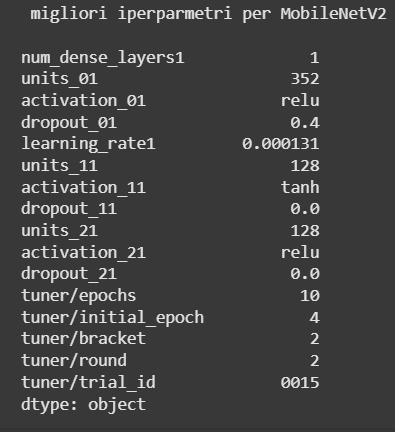

# MIGLIORI IPERPARAMETRI INDIVIDUARI PER RESNET50 CON KERAS-TUNER:

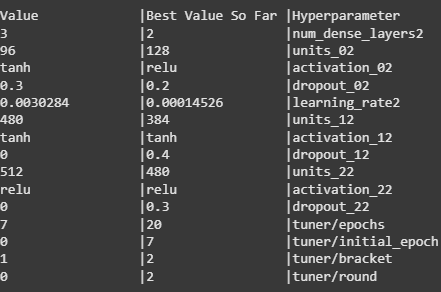

# 4) ADDESTRAMENTO DEI MODELLI BASE E CALCOLO DI ACCURACY E COSTO COMPUTAZIONALE (TEMPO DI INFERENZA E DIMENSIONE DEL MODELLO)




4.1  Costruzione e addestramento finale dei modelli base.

4.2  Calcolo dell'accuratezza dei modelli con confronto grafico (anche per capire la differenza di andamento in funzione delle epoche di training).

4.3  Calcolo del tempo medio di inferenza delle features (è il tempo che il modello impiega a classificare una feature mai vista fino ad adesso).

4.4  Calcolo della dimensione dei modelli



9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 65s 78ms/step - accuracy: 0.8041 - loss: 0.6711 - val_accuracy: 0.9604 - val_loss: 0.1324
Epoch 2/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 36s 55ms/step - accuracy: 0.9523 - loss: 0.1555 - val_accuracy: 0.9631 - val_loss: 0.1184
Epoch 3/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.9649 - loss: 0.1129 - val_accuracy: 0.9656 - val_loss: 0.1114
Epoch 4/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - accuracy: 0.9728 - loss: 0.0947 - val_accuracy: 0.9675 - val_loss: 0.1090
Epoch 5/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 40s 48ms/step - accuracy: 0.9765 - loss: 0.0788 - val_accuracy: 0.9682 - val_loss: 0.1064
Epoch 6/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 42s 49ms/step - accuracy: 0.9811 - loss: 0.0653 - val_accuracy: 0.9667 - val_loss: 0.1075
Epoch 7/10
654/654 ━━━━━━━━━━━━━━━━━━━━ 31s 47ms/step - accuracy: 0.9844 - loss: 0.0520 - val_accuracy: 0.9690 - val_los

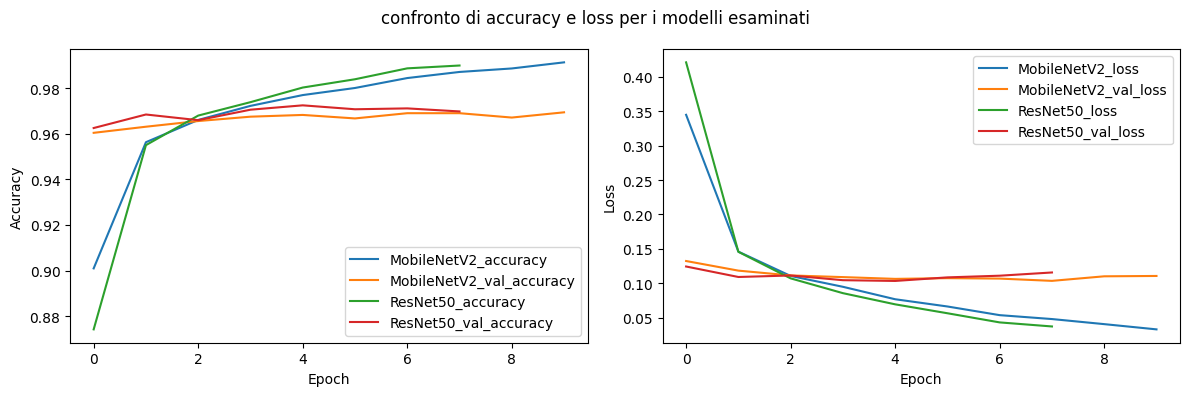

In [9]:
#4.1 Costruzione dei modelli finali (che contengono i migliori hyperparameter trovati con keras_tuner)
model_MobileNetV2= build_model_MobileNetV2()
model_ResNet50= build_model_ResNet50()

#   Addestramento dei modelli
history_MobileNetV2= model_MobileNetV2.fit(train_dataset_MobileNetV2, epochs=10, validation_data=val_dataset_MobileNetV2, callbacks=[callbacks], verbose=1)
history_ResNet50= model_ResNet50.fit(train_dataset_ResNet50, epochs=10, validation_data=val_dataset_ResNet50, callbacks=[callbacks], verbose=1)

#4.2  Calcoliamo l'accuracy e la loss dei modelli sui validation_set (li uservemo successivamente per il confronto finale)
loss_base_MobileNetV2, accuracy_base_MobileNetV2 = model_MobileNetV2.evaluate(val_dataset_MobileNetV2, verbose=0)
loss_base_ResNet50, accuracy_base_ResNet50 = model_ResNet50.evaluate(val_dataset_ResNet50, verbose=0)

#  Grafichiamo accuracy, val_accuracy, loss e val_loss per un confronto tra i modelli

plt.figure(figsize=(12, 4))
plt.suptitle("confronto di accuracy e loss per i modelli esaminati")
plt.subplot(1, 2, 1)
plt.plot(history_MobileNetV2.history['accuracy'], label='MobileNetV2_accuracy')
plt.plot(history_MobileNetV2.history['val_accuracy'], label='MobileNetV2_val_accuracy')
plt.plot(history_ResNet50.history['accuracy'], label='ResNet50_accuracy')
plt.plot(history_ResNet50.history['val_accuracy'], label='ResNet50_val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_MobileNetV2.history['loss'], label='MobileNetV2_loss')
plt.plot(history_MobileNetV2.history['val_loss'], label='MobileNetV2_val_loss')
plt.plot(history_ResNet50.history['loss'], label='ResNet50_loss')
plt.plot(history_ResNet50.history['val_loss'], label='ResNet50_val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()



In [ ]:

#4.2  CREAZIONE DELLA FUNZIONE PER MISURARE IL TEMPO DI INFERENZA MEDIA


# passo come argomenti il modello (MobileNetV2 o ResNet50),con il relativo dataset normalizzato e valuto il tempo d'inferenza sullo stesso numero di feature
def Measure_inference_time(model, dataset, n_batch=5):

  # segno i tempi su una lista, che userò successivamente per trovare la media
  times = []

  # ciclo tutte le features all'interno degli n_batch, _ sarebbero le etichette che però non sono utili al nostro scopo
  for images, _ in dataset.take(n_batch):

    # segniamo il tempo di inizio per l'inferenza dell'n-esimo batch
    start_time = time.time()

    # effettuiamo l'inferenza sulle immagini dell n-esimo batch
    model.predict(images, verbose=0)

    # segniamo il tempo di fine per l'inferenza dell'n-esimo batch
    end_time = time.time()

    # aggiungiamo il tempo medio di inferenza per ogni immagine del n-esimo batch (infatti dividiamo per la dimensione del batch)
    times.append((end_time-start_time)/images.shape[0])

    # ritorno la media di tutti i tempi nella lista times
  return sum(times)/len(times)


#   Calcoliamo il tempo di inferenza medio per entrambi i modelli
time_MobileNetV2= Measure_inference_time(model_MobileNetV2, val_dataset_MobileNetV2)

time_ResNet50= Measure_inference_time(model_ResNet50, val_dataset_ResNet50)


#4.4 Salviamo i modelli sul NoteBok e determiniamo le dimensioni dei modelli in termini di MegaByte (dividenodo per 1024^2 poichè il peso è espresso in byte)
model_MobileNetV2.save('model_MobileNetV2.h5')
model_ResNet50.save('model_ResNet50.h5')

size_MobileNetV2= os.path.getsize('model_MobileNetV2.h5')/(1024*1024)
size_ResNet50= os.path.getsize('model_ResNet50.h5')/(1024*1024)


# 5) QUANTIZZAZIONE DEI MODELLI


5.1  Creazione delle funzione per effettuare il pre-processing sulle singole immagini.

5.2  Creazione dei Representative dataset, utilizzando la funzione per pre-processing creata precedentemente.

5.3   Conversione e quantizzazione di MobileNetV2 a modello tfLite (int 8).

5.4   Conversione e quantizzazione di ResNet50 a  modello tfLite (int 8).


In [11]:
#5.1 Per la creazione dei representative dataset utilizziamo raw_train_dataset (senza pre-processing)

#funzione per il pre-processing relativo a mobilenet
def preprocess_image_mobilenet(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.mobilenet_v2.preprocess_input(image)
    return image

#funzione per il pre-processing relativo a resnet
def preprocess_image_resnet(image):
    image = tf.image.resize(image, (224, 224))
    image = tf.keras.applications.resnet.preprocess_input(image)
    return image

# 5.2 creazione de representative Dataset

#Representative dataset per mobilenet
def representative_dataset_mobilenet():
    for images, _ in raw_train_dataset.take(20):
        for image in images:  # Cicla sulle immagini singole del batch
            preprocessed_image = preprocess_image_mobilenet(image)
            yield [tf.cast(tf.expand_dims(preprocessed_image, 0), tf.float32)]


# Representative dataset per resnet
def representative_dataset_resnet():
    for images, _ in raw_train_dataset.take(20):
        for image in images:
            preprocessed_image = preprocess_image_resnet(image)
            yield [tf.cast(tf.expand_dims(preprocessed_image, 0), tf.float32)]



#5.3 CREAZIONE DEL MODELLO tfLite DI MOBILENETV2

#Creiamo un oggetto TFLiteConverter che serve a gestire la conversione
converter_mobilenet= tf.lite.TFLiteConverter.from_keras_model(model_MobileNetV2)

#effettuiamo la conversione
converter_mobilenet.optimizations= [tf.lite.Optimize.DEFAULT]

#passiamo il representative_dataset al converter
converter_mobilenet.representative_dataset= representative_dataset_mobilenet

#specifichiamo la quantizzazione a int 8
converter_mobilenet.target_spec.supported_ops= [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

#convertiamo input e ourput in tipi uint8 (range[0-255])
converter_mobilenet.inference_input_type = tf.float32
converter_mobilenet.inference_output_type = tf.float32

# Creiamo il modello finale quantizzato
tflite_model_mobilenet_int8 = converter_mobilenet.convert()

#salviamo il modello
with open("model_MobileNetV2_int8.tflite", "wb") as f:
    f.write(tflite_model_mobilenet_int8)





#5.4 CREAZIONE DEL MODELLO tfLite DI RESNET50


# Creiamo un oggetto TFLiteConverter che serve a gestire la conversione
converter_resnet= tf.lite.TFLiteConverter.from_keras_model(model_ResNet50)

#effettuiamo la conversione
converter_resnet.optimizations= [tf.lite.Optimize.DEFAULT]

#passiamo il representative_dataset al converter
converter_resnet.representative_dataset= representative_dataset_resnet

#specifichiamo la quantizzazione a int 8
converter_resnet.target_spec.supported_ops= [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]

#convertiamo input e ourput in tipi uint8 (range[0-255])
converter_resnet.inference_input_type = tf.float32
converter_resnet.inference_output_type = tf.float32

# Creiamo il modello finale quantizzato
tflite_model_resnet_int8 = converter_resnet.convert()

#salviamo il modello
with open("model_ResNet50_int8.tflite", "wb") as f:
    f.write(tflite_model_resnet_int8)



Saved artifact at '/tmp/tmp64ol4x_q'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_154')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133791524826448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524829520: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524829136: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524827216: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524829904: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524828944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524830096: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524831056: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524830672: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524829328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791524

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


Saved artifact at '/tmp/tmpip57j_s4'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_335')
Output Type:
  TensorSpec(shape=(None, 10), dtype=tf.float32, name=None)
Captures:
  133791388948176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388948752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388948944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388947792: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388946448: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388948560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388952784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388953360: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388953552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388952400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133791388

/usr/local/lib/python3.11/dist-packages/tensorflow/lite/python/convert.py:997: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


# 6) CALCOLO DI ACCURACY E COSTO COMPUTAZIONALE PER I MODELLI QUANTIZZATI



6.1  Creazione della funzione per la valutazione delle metriche.

6.2  Esecuzione dei test.

6.3  Comparazione delle metriche tra i modelli quantizzati.



In [ ]:
#6.1 CREAZIONE DELLA FUNZIONE CHE USEREMO PER L'INFERENZA E LA MISURAZIONE DELLE METRICHE SUI MODELLI TFLITE

def evaluate_tfLite_model(tflite_model_path,dataset, class_names):

  # Caricamento del modello (creazione dell'interpeteur che ci servirà per effettuare l'inferenza)
  interpreter = tf.lite.Interpreter(model_path=tflite_model_path)

  #Allocazione dei tensori
  interpreter.allocate_tensors()

  #Estrazione dei metadati relativi agli input e gli output: shape, dtype etc.
  input_details= interpreter.get_input_details()
  output_details= interpreter.get_output_details()

  #Estrazione degli indici di input e output: serve per far capire all'interpeteur dove caricare l'input e dove leggere l'output
  input_index = input_details[0]['index']
  output_index = output_details[0]['index']



  # Inizializzazione dei parametri che useremo per calcolare le metriche

  total_time=0
  total_images=0
  correct_predictions=0

  # Inferenza

  #cicliamo sul dataset che contiene le images e le relative labels
  for images, labels in dataset:

    #convertiamo i tensori in array numpy
    images_np= images.numpy().astype(np.float32)
    labels_np= labels.numpy()
    batch_size= images_np.shape[0]

    #cicliamo tutte le immagini
    for i in range(batch_size):

      #estraggo la singola immagine dal dataset e aggiungo una dimensione in testa (1,height, width, channels)
      input_tensor = np.expand_dims(images_np[i], axis=0)

      #carico l'input nel modello utilizzando input_index
      interpreter.set_tensor(input_index, input_tensor)

      #segno il tempo di inizio
      start_time=time.time()

      #effettuo l'inferenza
      interpreter.invoke()

      #misuro il tempo il tempo impiegato come tempo finale - iniziale
      elapsed_time= time.time() - start_time

      #tempo totale che si aggiorna ad ogni inferenza
      total_time +=elapsed_time

      #prendo il vettore di probabilità con i relativi valori per ogni classe

      output= interpreter.get_tensor(output_index)[0]

      #prendo come predizione la classe con la percentuale maggiore
      predict= np.argmax(output)

      #controllo se la predizione è uguale al rispettivo target (e in caso aggiorno il numero totale di predizioni corrette)
      if predict== labels_np[i]:
        correct_predictions +=1

      #aggiorno il numero totale di immagini

      total_images +=1


  # Valutazione delle metriche finali

  accuracy= correct_predictions/total_images

  average_time= total_time/total_images

  model_size_MB= os.path.getsize(tflite_model_path)/(1024*1024)

  return accuracy, average_time, model_size_MB




#6.2 ESECUZIONE DEI TEST

# valutazione delle metriche per il modello mobilenet quantizzato

accuracy_tfLite_MobileNetV2, time_tfLite_MobileNetV2, size_tfLite_MobileNetV2 = evaluate_tfLite_model(
    tflite_model_path="model_MobileNetV2_int8.tflite",
    dataset=val_dataset_MobileNetV2.take(10),
    class_names=class_names
)

# valutazione delle metriche per il modello resnet quantizzato
accuracy_tfLite_ResNet50,time_tfLite_ResNet50, size_tfLite_ResNet50 = evaluate_tfLite_model(
    tflite_model_path="model_ResNet50_int8.tflite",
    dataset=val_dataset_ResNet50.take(10),
    class_names=class_names
)


#6.3 Comparazione dell'andamento delle metriche tra i modelli quantizzati

metriche= {
    'Model': ['MobileNetV2_tfLite', 'ResNet50_tfLite'],
    'Accuracy': [accuracy_tfLite_MobileNetV2, accuracy_tfLite_ResNet50],
    'Inference Time (s)': [time_tfLite_MobileNetV2, time_tfLite_ResNet50],
    'Size (MB)': [size_tfLite_MobileNetV2, size_tfLite_ResNet50]
}

df = pd.DataFrame(metriche, columns=['Model', 'Accuracy', 'Inference Time (s)', 'Size (MB)'])

print(df.to_string(index=False))


             Model  Accuracy  Inference Time (s)  Size (MB)
MobileNetV2_tfLite  0.984375            0.012287   3.027008
   ResNet50_tfLite  0.981250            0.117864  23.433487


# 7) CONFRONTO DELLE PRESTAZIONE TRA MODELLI BASE E QUANTIZZATI

In [13]:

data = {
    'Model': ['MobileNetV2_base', 'MobileNetV2_tfLite', 'ResNet50_base', 'ResNet50_tfLite'],
    'Accuracy': [accuracy_base_MobileNetV2, accuracy_tfLite_MobileNetV2, accuracy_base_ResNet50, accuracy_tfLite_ResNet50],
    'Inference Time (s)': [time_MobileNetV2, time_tfLite_MobileNetV2, time_ResNet50, time_tfLite_ResNet50],
    'Size (MB)': [size_MobileNetV2, size_tfLite_MobileNetV2, size_ResNet50, size_tfLite_ResNet50]
}

df = pd.DataFrame(data, columns=['Model', 'Accuracy', 'Inference Time (s)', 'Size (MB)'])

print(df.to_string(index=False))



             Model  Accuracy  Inference Time (s)  Size (MB)
  MobileNetV2_base  0.968995            0.022341  14.168869
MobileNetV2_tfLite  0.984375            0.012287   3.027008
     ResNet50_base  0.972440            0.033296  93.981934
   ResNet50_tfLite  0.981250            0.117864  23.433487


#8) CONCLUSIONI

Con questo progetto abbiamo analizzato l'approccio di classificazione di immagini animali basato sul transfer learning, in particolare ci siamo avvalsi dell'uso di MobilNetV2 e ResNet50.
Abbiamo in eseguito la quantizzazione post-training sui modelli, confrontandone prestazioni e costi computazionali con i relativi base_model.
Sulla base dei risultati ottenuti possiamo fare le seguenti osservazioni sulle singole metriche:


1.   ACCURATEZZA: I modelli quantizzati hanno mantenuto valori di accuratezza molto vicini a quelli dei modelli base: ad esempio, MobileNetV2 è passato da 0.969 a 0.984, e ResNet50 da 0.972 a 0.981. Questo ci fa capire che la quantizzazione può non compromettere significativamente l’accuratezza, e in alcuni casi rari può persino migliorarla leggermente.

2.   TEMPO DI INFERENZA: si è notato che i tempi di inferenza si sono significativamente abbassati (da 0.022 a 0.012 per mobilenet e da 0.033 a 0.11 per resNet), resnet però dimostra che l'effetto della quantizzazione può variare in base all'architetura della rete.

3.   DIMENSIONI DEL MODELLO: Le dimensioni dei modelli sono state ridotte significativamente (mobilenet passa da circa 14.16 MB a soli 3.02 MB, resnet da 93.98 MB a 23.43 MB), ciò può facilitare l'uso di questi modelli in ambienti con alti vincoli di memoria.


Dalle osservazioni effettuate possiamo confermare che la quantizzazione è una strategia efficace per rendere modelli di machine learning più sostenibili, riducendo (nella maggioranza dei casi) dimensioni e tempo d'inferenza e riuscedo addirittura a migliorarne la generalizzazione.
Questi aspetti rendono questi moedelli ideali come per applicazioni real-time su dispositivi mobili dove le risorse di mnemoria e calcolo sono limitate.
Infine l'approccio basato su Transfer learning si è rivelato non solo efficiente (combinato alla quantizzazione post-training), ma anche facilmente scalabile e replicabile su problemi simili.